<a href="https://colab.research.google.com/github/greentfrapp/lucent/blob/master/notebooks/activation_grids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Activation Grids

This is the Lucent version of Lucid's [notebook](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/building-blocks/ActivationGrid.ipynb)
on Activation Grids. The original notebook is itself based on its own paper available at [**corresponding paper**](https://distill.pub/2018/building-blocks).


## Install, Import, Load Model

In [0]:
!pip install --quiet git+https://github.com/mehdidc/lucent@activation_grids_notebook

!wget -qnc https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png

In [0]:
from itertools import product
import sys
from PIL import Image

import numpy as np
import torch
import torchvision

from lucent.modelzoo import *
from lucent.misc.io import show
import lucent.optvis.objectives as objectives
import lucent.optvis.param as param
import lucent.optvis.render as render
import lucent.optvis.transform as transform
from lucent.misc.channel_reducer import ChannelReducer
from lucent.misc.io import show

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = inceptionv1(pretrained=True)
_ = model.to(device).eval()

## Helper functions

In [0]:
@torch.no_grad()
def get_layer(model, layer, X):
    hook = render.ModuleHook(getattr(model, layer))
    model(X)
    hook.close()
    return hook.features


@objectives.wrap_objective()
def dot_compare(layer, acts, batch=1):
    def inner(T):
        pred = T(layer)[batch]
        return -(pred * acts).sum(dim=0, keepdims=True).mean()

    return inner

## Very Naive implementation


From the original notebook:


"This first implementation is a simplified, instructive demonstration of how to make activation grids.

Unfortunately, it has two problems:

* **Coherence:** At high levels, activation vectors can be quite abstract and correspond to a multi-modal input distribution. If we visualize them completely independently, we often end up with things being kind of incoherent. For example, some dog snouts may face left and some right. This can be visually distracting.
* **Memory:** It can run out of memory when you try to visualize large grids (eg. on low level layers with high spatial resolution)

We'll address these in more complicated implementations shortly."

In [0]:
def render_activation_grid_very_naive(
    img, model, layer="mixed4d", cell_image_size=48, n_steps=1024
):
    # First wee need, to normalize and resize the image
    img = torch.tensor(np.transpose(img, [2, 0, 1])).to(device)
    normalize = (
        transform.preprocess_inceptionv1()
        if model._get_name() == "InceptionV1"
        else transform.normalize()
    )
    transforms = [
        normalize,
        torch.nn.Upsample(size=224, mode="bilinear", align_corners=True),
    ]
    transforms_f = transform.compose(transforms)
    # shape: (1, 3, original height of img, original width of img)
    img = img.unsqueeze(0)
    # shape: (1, 3, 224, 224)
    img = transforms_f(img)

    # Here we compute the activations of the layer `layer` using `img` as input
    # shape: (layer_channels, layer_height, layer_width), the shape depends on the layer
    acts = get_layer(model, layer, img)[0]
    layer_channels, layer_height, layer_width = acts.shape
    # for each position `(y, x)` in the feature map `acts`, we optimize an image
    # to match with the features `acts[:, y, x]`
    # This means that the total number of cells (which is the batch size here) 
    # in the grid is layer_height*layer_width.
    nb_cells = layer_height * layer_width

    # Parametrization of the of each cell in the grid
    param_f = lambda: param.image(
        cell_image_size, batch=nb_cells
    )
    params, image_f = param_f()

    obj = objectives.Objective.sum(
        [
            # for each position in `acts`, maximize the dot product between the activations
            # `acts` at the position (y, x) and the features of the corresponding
            # cell image on our 'grid'. The activations at (y, x) is a vector of size
            # `layer_channels` (this depends on the `layer`). The features
            # of the corresponding cell on our grid is a tensor of shape
            # (layer_channels, cell_layer_height, cell_layer_width).
            # Note that cell_layer_width != layer_width and cell_layer_height != layer_weight
            # because the cell image size is smaller than the image size.
            # With `dot_compare`, we maximize the dot product between
            # cell_activations[y_cell, x_xcell] and acts[y,x] (both of size `layer_channels`)
            # for each possible y_cell and x_cell, then take the average to get a single
            # number. Check `dot_compare for more details.`
            dot_compare(layer, acts[:, y:y+1, x:x+1], batch=x + y * layer_width)
            for i, (x, y) in enumerate(product(range(layer_width), range(layer_height)))
        ]
    )
    results = render.render_vis(
        model,
        obj,
        param_f,
        thresholds=(n_steps,),
        progress=True,
        fixed_image_size=cell_image_size,
        show_image=False,
    )
    # shape: (layer_height*layer_width, cell_image_size, cell_image_size, 3)
    imgs = results[-1] # last step results
    # shape: (layer_height*layer_width, 3, cell_image_size, cell_image_size)
    imgs = imgs.transpose((0, 3, 1, 2))
    imgs = torch.from_numpy(imgs)
    imgs = imgs[:, :, 2:-2, 2:-2]
    # turn imgs into a a grid
    grid = torchvision.utils.make_grid(imgs, nrow=int(np.sqrt(nb_cells)), padding=0)
    grid = grid.permute(1, 2, 0)
    grid = grid.numpy()
    render.show(grid)
    return imgs

100%|██████████| 1024/1024 [07:06<00:00,  2.40it/s]



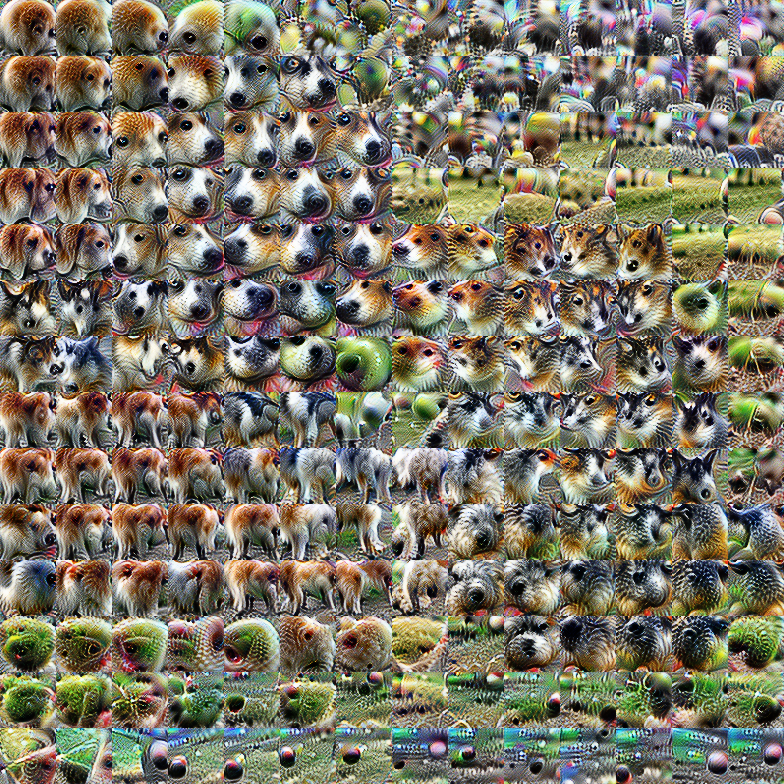

In [0]:
img = np.array(Image.open("dog_cat.png"), np.float32)
_ = render_activation_grid_very_naive(img, model, cell_image_size=60, n_steps=1024)

## Better Implementation

In [0]:
def render_activation_grid_less_naive(
    img,
    model,
    layer="mixed4d",
    cell_image_size=60,
    n_groups=6,
    n_steps=1024,
    batch_size=64,
):
    # First wee need, to normalize and resize the image
    img = torch.tensor(np.transpose(img, [2, 0, 1])).to(device)
    normalize = (
        transform.preprocess_inceptionv1()
        if model._get_name() == "InceptionV1"
        else transform.normalize()
    )
    transforms = transform.standard_transforms.copy() + [
        normalize,
        torch.nn.Upsample(size=224, mode="bilinear", align_corners=True),
    ]
    transforms_f = transform.compose(transforms)
    # shape: (1, 3, original height of img, original width of img)
    img = img.unsqueeze(0)
    # shape: (1, 3, 224, 224)
    img = transforms_f(img)

    # Here we compute the activations of the layer `layer` using `img` as input
    # shape: (layer_channels, layer_height, layer_width), the shape depends on the layer
    acts = get_layer(model, layer, img)[0]
    # shape: (layer_height, layer_width, layer_channels)
    acts = acts.permute(1, 2, 0)
    # shape: (layer_height*layer_width, layer_channels)
    acts = acts.view(-1, acts.shape[-1])
    acts_np = acts.cpu().numpy()
    nb_cells = acts.shape[0]

    # negative matrix factorization `NMF` is used to reduce the number
    # of channels to n_groups. This will be used as the following.
    # Each cell image in the grid is decomposed into a sum of
    # (n_groups+1) images. First, each cell has its own set of parameters
    #  this is what is called `cells_params` (see below). At the same time, we have
    # a of group of images of size 'n_groups', which also have their own image parametrized
    # by `groups_params`. The resulting image for a given cell in the grid
    # is the sum of its own image (parametrized by `cells_params`)
    # plus a weighted sum of the images of the group. Each each image from the group
    # is weighted by `groups[cell_index, group_idx]`. Basically, this is a way of having
    # the possibility to make cells with similar activations have a similar image, because
    # cells with similar activations will have a similar weighting for the elements
    # of the group.
    if n_groups > 0:
        reducer = ChannelReducer(n_groups, "NMF")
        groups = reducer.fit_transform(acts_np)
        groups /= groups.max(0)
    else:
        groups = np.zeros([])
    # shape: (layer_height*layer_width, n_groups)
    groups = torch.from_numpy(groups)

    # Parametrization of the images of the groups (we have 'n_groups' groups)
    groups_params, groups_image_f = param.fft_image(
        [n_groups, 3, cell_image_size, cell_image_size]
    )
    # Parametrization of the images of each cell in the grid (we have 'layer_height*layer_width' cells)
    cells_params, cells_image_f = param.fft_image(
        [nb_cells, 3, cell_image_size, cell_image_size]
    )

    # First, we need to construct the images of the grid
    # from the parameterizations

    def image_f():
        groups_images = groups_image_f()
        cells_images = cells_image_f()
        X = []
        for i in range(nb_cells):
            x = 0.7 * cells_images[i] + 0.5 * sum(
                groups[i, j] * groups_images[j] for j in range(n_groups)
            )
            X.append(x)
        X = torch.stack(X)
        return X

    # make sure the images are between 0 and 1
    image_f = param.to_valid_rgb(image_f, decorrelate=True)

    # After constructing the cells images, we sample randomly a mini-batch of cells
    # from the grid. This is to prevent memory overflow, especially if the grid
    # is large.
    def sample(image_f, batch_size):
        def f():
            X = image_f()
            inds = torch.randint(0, len(X), size=(batch_size,))
            inputs = X[inds]
            # HACK to store indices of the mini-batch, because we need them
            # in objective func. Might be better ways to do that
            sample.inds = inds
            return inputs

        return f

    image_f_sampled = sample(image_f, batch_size=batch_size)

    # Now, we define the objective function

    def objective_func(model):
        # shape: (batch_size, layer_channels, cell_layer_height, cell_layer_width)
        pred = model(layer)
        # use the sampled indices from `sample` to get the corresponding targets
        target = acts[sample.inds].to(pred.device)
        # shape: (batch_size, layer_channels, 1, 1)
        target = target.view(target.shape[0], target.shape[1], 1, 1)
        dot = (pred * target).sum(dim=1).mean()
        return -dot

    obj = objectives.Objective(objective_func)

    def param_f():
        # We optimize the parametrizations of both the groups and the cells
        params = list(groups_params) + list(cells_params)
        return params, image_f_sampled

    results = render.render_vis(
        model,
        obj,
        param_f,
        thresholds=(n_steps,),
        show_image=False,
        progress=True,
        fixed_image_size=cell_image_size,
    )
    # shape: (layer_height*layer_width, 3, grid_image_size, grid_image_size)
    imgs = image_f()
    imgs = imgs.cpu().data
    imgs = imgs[:, :, 2:-2, 2:-2]
    # turn imgs into a a grid
    grid = torchvision.utils.make_grid(imgs, nrow=int(np.sqrt(nb_cells)), padding=0)
    grid = grid.permute(1, 2, 0)
    grid = grid.numpy()
    render.show(grid)
    return imgs

100%|██████████| 1024/1024 [04:37<00:00,  3.69it/s]



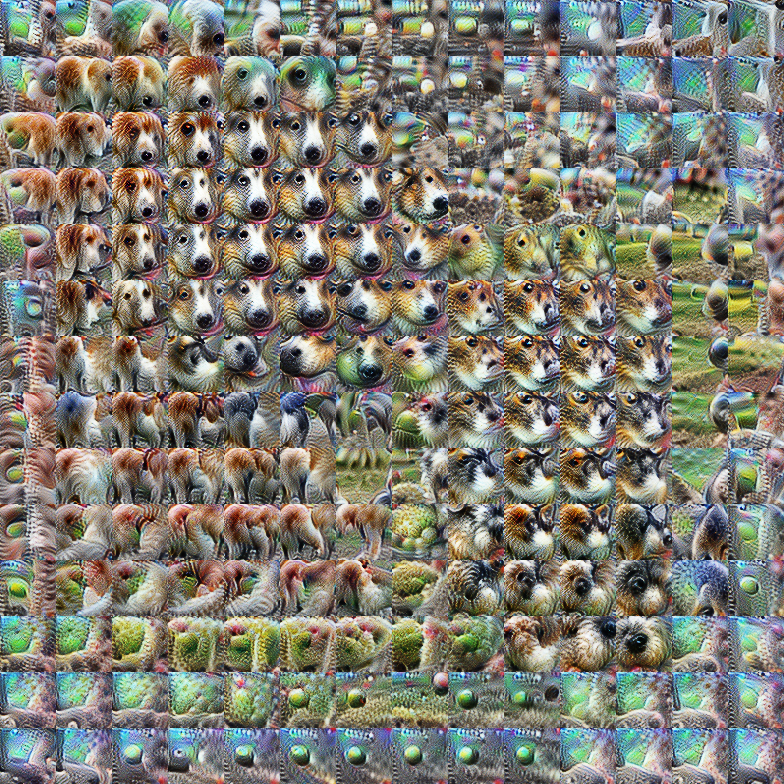

In [0]:
_ = render_activation_grid_less_naive(
    img, model, cell_image_size=60, n_steps=1024, batch_size=64
)